In [5]:
import nltk
# nltk.download('punkt')
from nltk.tokenize import word_tokenize


def read_data(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

        # tokenize with nltk
    lines = [word_tokenize(line) for line in lines]

    # convert to lowercase
    lines = [[token.lower() for token in line] for line in lines]

    # if token contains digits, replace it with __NUM
    for line in lines:
        for i in range(len(line)):
            if any(char.isdigit() for char in line[i]):
                line[i] = '__NUM'

    # join tokens into a sentence
    # lines = [' '.join(line) for line in lines]

    return lines

# data = {
#     'ours_formal': 'StyleINS/ours_formal.txt',
#     'ours_informal': 'StyleINS/ours_informal.txt',
#     'gyafc_formal': 'StyleINS/gyafc_test_formal.txt',
#     'gyafc_informal': 'StyleINS/gyafc_informal.txt',
# }

data = {
    'ours_formal': 'Intro_to_NLP/Project/StyleINS/ours_formal.txt',
    'ours_informal': 'Intro_to_NLP/Project/StyleINS/ours_informal.txt',
    'gyafc_formal': 'Intro_to_NLP/Project/StyleINS/gyafc_test_formal.txt',
    'gyafc_informal': 'Intro_to_NLP/Project/StyleINS/gyafc_informal.txt',
}

# read data
data = {k: read_data(v) for k, v in data.items()}

# print first 5 sentences from each dataset
for k, v in data.items():
    print(k)
    for line in v[:5]:
        print(line)
    print()

ours_formal
['do', "n't", 'ever', 'let', 'somebody', 'tell', 'you', 'that', 'you', 'can', 'not', 'do', 'something', ',', 'not', 'even', 'me', '.']
['i', 'am', 'the', 'type', 'of', 'person', 'who', ',', 'if', 'you', 'ask', 'me', 'a', 'question', 'and', 'i', 'do', "n't", 'know', 'the', 'answer', ',', 'i', 'will', 'inform', 'you', 'that', 'i', 'do', 'not', 'know', '.']
['however', ',', 'i', 'am', 'confident', 'that', 'i', 'have', 'the', 'skills', 'to', 'find', 'the', 'answer', 'and', 'will', 'do', 'so', '.']
['there', 'is', 'an', "'", 'i', "'", 'in', '``', 'happiness', ',', "''", 'and', 'there', 'is', 'no', "'", 'y', '.', "'", 'it', 'is', 'spelled', 'with', 'an', "'", 'i', '.', "'"]
['if', 'you', 'have', 'a', 'dream', ',', 'you', 'must', 'protect', 'it', '.']

ours_informal
['do', "n't", 'ever', 'let', 'somebody', 'tell', 'you', 'you', 'ca', "n't", 'do', 'something', ',', 'not', 'even', 'me', '.']
['i', "'m", 'the', 'type', 'of', 'person', ',', 'if', 'you', 'ask', 'me', 'a', 'question', '

In [6]:
from nltk.metrics.distance import edit_distance

def levenshtein_edit_distance(dataset_0, dataset_1):
    edit_distances = []

    for i in range(len(dataset_0)):
        edit_distances.append(
            edit_distance(
                ' '.join(dataset_0[i]),
                ' '.join(dataset_1[i])
            )
        )
    return edit_distances

edit_distances = {
    'ours': levenshtein_edit_distance(data['ours_formal'], data['ours_informal']),
    'gyafc': levenshtein_edit_distance(data['gyafc_formal'], data['gyafc_informal'])
}

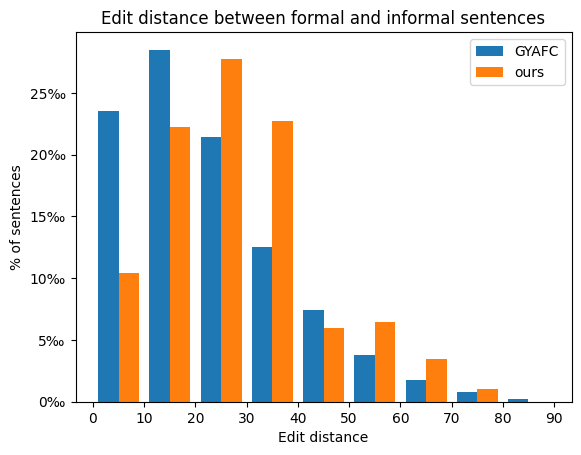

In [9]:
# create a diagram of edit distances, x axis: edit distances, bins of 10, 0 to 80, y axis: % of sentences
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter


# plt.style.use('seaborn-deep')

fig, ax = plt.subplots()



x = edit_distances['gyafc']
y = edit_distances['ours']
bins = np.linspace(0, 90, 10)

ax.hist([x, y], bins, label=['GYAFC', 'ours'], density=True)
ax.legend(loc='upper right')

ax.set_title('Edit distance between formal and informal sentences')
ax.set_xlabel('Edit distance')
ax.set_ylabel('% of sentences')

# set x axis ticks as [0, 10) with step 10
ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y*1000:.0f}‰'))

# save figure to plots
plt.savefig('Intro_to_NLP/Project/plots/edit_distance.png')
plt.show()


In [3]:
from transformers import BertModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
_ = model.eval()

In [12]:
from transformers import BertModel
from transformers import BertTokenizer

import torch
import numpy as np

def sentence_embeddings(dataset):
    # create an embedding of each sentence with bert
    
    with torch.no_grad():
        embeddings = []
        for sentence in dataset:
            # tokenize sentence
            sentence = ' '.join(sentence)
            tokens = tokenizer.encode(sentence, add_special_tokens=True)
            tokens = torch.tensor(tokens).unsqueeze(0)
            # get embedding
            output = model(tokens)
            embeddings.append(output[0][0][0].numpy())
            
    embeddings = np.array(embeddings)
    return embeddings
    
# calculate embeddings of ours_informal and gyafc_informal

embeddings = {
    'ours': sentence_embeddings(data['ours_informal']),
    'gyafc': sentence_embeddings(data['gyafc_informal'])
}

In [17]:
# reduce the dimensionality of the embeddings to 2D with PCA
from sklearn.decomposition import PCA

def reduce_dimensionality(embeddings):
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(embeddings)
    return embeddings

embeddings_pca = {k: reduce_dimensionality(v) for k, v in embeddings.items()}

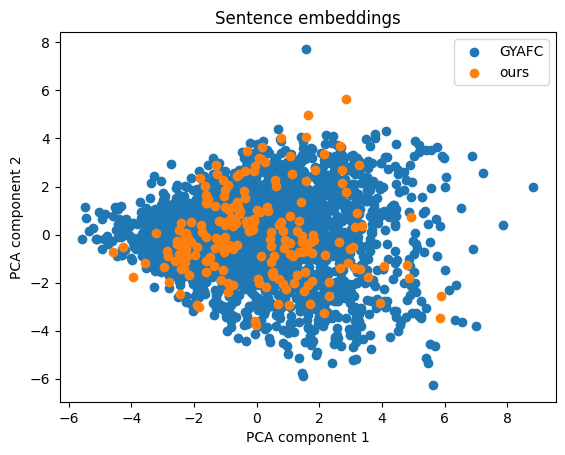

In [20]:
# plot the embeddings
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

x = embeddings_pca['gyafc'][:, 0]
y = embeddings_pca['gyafc'][:, 1]
ax.scatter(x, y, label='GYAFC')

x = embeddings_pca['ours'][:, 0]
y = embeddings_pca['ours'][:, 1]
ax.scatter(x, y, label='ours')

ax.legend(loc='upper right')

ax.set_title('Sentence embeddings')
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')

# save figure to plots
plt.savefig('Intro_to_NLP/Project/plots/embeddings.png')
plt.show()
